In [15]:
import numpy as np
import matplotlib.pyplot as plt
import tkinter
import simpy
import random
import time 
import pandas as pd
import csv
from sklearn import cluster

In [16]:
class Location:
    def __init__(self, name=None, distance=None, river=None, distance_cluster=None):
        self.name = name
        self.distance = distance
        self.river = river
        self.cluster = cluster

In [17]:
class Call:
    id_call = 0 
    def __init__(self, ID=None, initial_time=None, final_time=None, status=None, location=None):
        Call.id_call = Call.id_call + 1
        self.ID = Call.id_call
        self.initial_time = initial_time
        self.final_time = final_time
        self.status = status 
        self.location = location
         
        
    def detail(self):
        print('Call from {} received at {}'.format(self.location.name, self.initial_time))
        
    def generate_Call(self, env, beta, distance_SB, p, AB, SB_negro, SB_amazonas, boat_list, lastCall=None):
        self.location = Location()
        self.location.name = random.choices([*distance], p)[0]
        self.location.distance = distance[self.location.name][0]
        self.location.river = distance[self.location.name][1]
        self.location.cluster = distance_SB[self.location.name][2]
        

        if (lastCall==None):
            self.initial_time = float (np.random.exponential(scale=beta, size=1))
            yield env.timeout(self.initial_time)
        else:    
            self.initial_time = float (lastCall.initial_time + np.random.exponential(scale=beta, size=1))
            yield env.timeout(self.initial_time)

        print('%7.4f Call %d received from %s. principal base distance : %d, river : %s, cluster center distance : %d, cluster : %d' % (env.now, self.ID, self.location.name, self.location.distance, self.location.river, distance_SB[self.location.name][0], self.location.cluster))
        print("estimated time in the first model : {}".format(2*(self.location.distance/boat_list[0].speed) + 0.25))
        if(self.location.river == "amazonas"): 
            yield env.process(trajet(boat_list_amazonas, SB_amazonas, "cluster_amazonas", self))       
        else: 
            yield env.process(trajet(boat_list_negro, SB_negro, "cluster_negro", self))
        
        self.status = 1
        

In [18]:
def trajet(boat_list_river, resource, cluster_name, self): 
    with resource.request() as req : 
        yield req
        time = 0 
        time_to_location = 0
        wait = env.now - self.initial_time #waiting time 
        start = env.now
        i = 0 
        if(boat_list_river[self.location.cluster].status == 0): 
            i = self.location.cluster
        else: 
            k = self.location.cluster-1 
            l = self.location.cluster+1
            if(k<0): 
                k = 0
            if(l == len(boat_list_river)): 
                l = len(boat_list_river)-1
            recherche = True 
            while(recherche):
                if(k>=0 or l<len(boat_list_river)):
                    plus_proche_base = min(distance_SB[cluster_name+str(boat_list_river[k].cluster)], 
                                           distance_SB[cluster_name+str(boat_list_river[l].cluster)])
                    if(plus_proche_base == distance_SB[cluster_name+str(boat_list_river[k].cluster)]): 
                        if(boat_list_river[k].status == 0):
                            recherche = False 
                            i = k
                        else: 
                            k = k-1
                    else: 
                        if(boat_list_river[l].status == 0):
                            recherche = False 
                            i = l
                        else: 
                            if(l != len(boat_list_river)):
                                l =l+1
        print('%7.4f Departure of the simple boat %s %d from cluster %d'%(env.now, self.location.river, boat_list_river[i].ID, boat_list_river[i].cluster))
        if(i != len(boat_list_river) and boat_list_river[i].status == 0):
            boat_list_river[i].status = 1
            if(boat_list_river[i].cluster == self.location.cluster): 
                time_to_location = distance_SB[self.location.name][0]/boat_list_river[i].speed
                time = time_to_location + self.location.distance/boat_list_river[i].speed
            else:
                time_to_location = abs(distance_SB[cluster_name+str(boat_list_river[i].cluster)] - 
                                       distance_SB[cluster_name+str(self.location.cluster)])/boat_list_river[i].speed + distance_SB[self.location.name][0]/boat_list_river[i].speed
                time = time_to_location + self.location.distance/boat_list_river[i].speed
            initial_AB = env.now
            with AB.request() as req_AB:
                yield req_AB
                wait_AB = env.now - initial_AB #temps d'attente du bateau avancé 
                print('%7.4f Departure of the advanced boat'%(env.now))
                j = 0 
                while(j != len(boat_list) and boat_list[j].status != 0): #while you don't have a boat available 
                    j = j + 1
                if(j != len(boat_list) and boat_list[j].status == 0):
                    boat_list[j].status = 1
                    intervention = Intervention()
                    intervention.boat_SB = boat_list_river[i]
                    intervention.boat_AB = boat_list[j]
                    intervention.call = self
                    intervention.waited_time = wait 
                    intervention.TOS = 0.25
                    if(self.location.distance/boat_list[j].speed < distance_SB[self.location.name][0]/boat_list_river[i].speed):
                        t = 2*(self.location.distance/boat_list[j].speed)
                        boat_list_river[i].status = 0 
                        distance_to_base = distance_SB[cluster_name+str(boat_list_river[i].cluster)]  
                    else:
                        if(env.now > start + time ): 
                            print('appel traité par le boat simple')
                            distance_to_base = (env.now - start - time )*boat_list_river[i].speed
                            t = 0
                        else: 
                            reste = start + time - env.now #temps qu'il reste pour que le simple boat finisse le trajet 
                            if(reste<time-time_to_location): #si je suis déjà arrivé à la location et que je suis reparti  
                                d = reste*boat_list_river[i].speed #c'est la distance qu'il reste à parcourir au simple boat, autrement dit la distance entre le simple boat et la base principale 
                                t = 2*(d/(boat_list_river[i].speed + boat_list[j].speed))
                            else: #si je suis entre le cluster et la location 
                                d1 = (time_to_location-(time-reste))*boat_list[j].speed #(time - reste) represente la distance deja parcouru par le simple boat. Et comme reste > time-TTL, TTL-(time-reste) est positif
                                t = 2*(time_to_location-(time-reste)) + 2*((self.location.distance-d1)/(boat_list_river[i].speed + boat_list[j].speed)) #on fait distance-d1 car c'est la distance que l'AB a deja parcouru 
                            distance_to_base = boat_list[j].speed*(t/2) # distance qui sépare le bateau avancé de la base principale
                    intervention.travel_time = t/2 #attention ce n'est pas la definiton du travel time 
                    intervention.response_time = intervention.travel_time + intervention.TOS
                    intervention.road_time = t + intervention.TOS + wait_AB 
                    inter_list.append(intervention)
                    self.final_time = self.initial_time + intervention.road_time 
                    yield env.timeout(intervention.travel_time + intervention.TOS)
                    print('%7.4f Call %d: exchange in course' % (env.now, self.ID))
                    echange = env.now
                    yield env.timeout(intervention.travel_time)
                    print("real execution time {}".format(t + intervention.TOS + wait_AB )) 
                    print('%7.4f Call %d: Finished' % (env.now, self.ID))
                    boat_list[j].status = 0
                    boat_list_river[i].status = 0 
                    
        distance_to_cluster = abs(distance_SB[cluster_name+str(boat_list_river[i].cluster)] - distance_to_base) #distance entre le point d'échange et le cluster 
        print("distance_to_cluster : {} distance_to_base : {} cluster : {}".format(distance_to_cluster, distance_to_base, distance_SB[cluster_name+str(boat_list_river[i].cluster)]))
        print("estimated time to come back : {}".format(distance_to_cluster/boat_list_river[i].speed))
        if(env.now > echange + distance_to_cluster/boat_list_river[i].speed): #on regarde ou se situe le bateau lorsque le bateau avancé arrive à la base 
            print('%7.4f boat %s %d : Arrived yet'%(env.now, self.location.river, boat_list_river[i].ID))
        else:
            print('%7.4f boat %s %d : On the way to come back '%(env.now, self.location.river, boat_list_river[i].ID))
            distance_restante = abs(distance_to_cluster - (env.now - echange)*boat_list_river[i].speed) #distance qu'il reste au bateau simple pour arriver au cluster
            print("distance_restante : {}".format(distance_restante))
            yield env.timeout(distance_restante/boat_list_river[i].speed)
            print('%7.4f boat %s %d : Arrived at the center'%(env.now, self.location.river, boat_list_river[i].ID))

In [19]:
class Intervention: 
    nb_inter = 0 
    def __init__(self, travel_time=None, TOS=None, response_time=None, road_time = None, waited_time=None, boat_SB=None, boat_AB=None, call=None):
        Intervention.nb_inter = Intervention.nb_inter + 1 
        self.ID = Intervention.nb_inter
        self.travel_time = travel_time
        self.TOS = TOS
        self.response_time = response_time 
        self.road_time = road_time 
        self.waited_time = waited_time 
        self.boat_SB = boat_SB
        self.boat_AB = boat_AB
        self.call = call
        
    def to_dict(self): 
        return {
            'Cluster du call': self.call.location.cluster,
            'Simple Boat': self.boat_SB.ID,
            'Cluster boat': self.boat_SB.cluster,
            'Advanced Boat': self.boat_AB.ID, 
            'Call traited': self.call.ID,
            'Call location': self.call.location.name, 
            'travel time': self.travel_time,
            'response time': self.response_time,
            'waited time': self.waited_time,
            'total time': self.road_time, 
        }

In [20]:
class Boat: 
    nb_boat = 0 
    def __init__(self, env, speed=None, status=None, cluster=None): 
        Boat.nb_boat = Boat.nb_boat + 1 
        self.ID = Boat.nb_boat 
        self.speed = speed 
        self.status = status 
        self.cluster = cluster

In [21]:
def clustering(distance, nb_boat_simple): 
    distance_negro = []
    distance_amazonas = []
    for i in range(len(distance)): #on regarde le fleuve de chaque location pour permettre de faire un cluster par bras de fleuve  
        if(distance[[*distance][i]][1] == 'amazonas'):
            distance_amazonas.append([0,distance[[*distance][i]][0]]) #on est obligé de mettre [0, distance] pour la fonction de clustering 
        else: 
            distance_negro.append([0,distance[[*distance][i]][0]])
    #on définit les paramètres du calcul des clusters 
    kmeans_negro = cluster.KMeans(n_clusters=nb_boat_simple, max_iter=1000) 
    kmeans_amazonas = cluster.KMeans(n_clusters=nb_boat_simple, max_iter=1000)
    
    #on réalise les calculs 
    kmeans_amazonas.fit(distance_amazonas)
    kmeans_negro.fit(distance_negro) 
    
    #on calcule pour chaque fleuve la distance des locations par rapport au nouveau centre 
    for i in range(len(kmeans_amazonas.labels_)): 
        distance_amazonas[i][1] = abs(distance_amazonas[i][1]-kmeans_amazonas.cluster_centers_[kmeans_amazonas.labels_[i]][1])
    for i in range(len(kmeans_negro.labels_)): 
        distance_negro[i][1] = abs(distance_negro[i][1]-kmeans_negro.cluster_centers_[kmeans_negro.labels_[i]][1])
        
    #on recrée le dictionnaire initial avec les nouvelles distances. Comme c'est dans le même ordre qu'à l'aller, le
    #dictionnaire se recrée tout seul automatiquement 
    distance_SB = {}
    for loc in [*distance]: 
        if(distance[loc][1] == 'amazonas'): 
            distance_SB[loc] = (distance_amazonas[0][1], 'amazonas', kmeans_amazonas.labels_[0])
            kmeans_amazonas.labels_ = np.delete(kmeans_amazonas.labels_, 0)
            del distance_amazonas[0] #on est obligé de faire pop l'élément pour pouvoir recréer le dictionnaire dans le même ordre
        else: 
            distance_SB[loc] = (distance_negro[0][1], 'negro', kmeans_negro.labels_[0])
            kmeans_negro.labels_ = np.delete(kmeans_negro.labels_, 0)
            del distance_negro[0]
    for i in range(len(kmeans_amazonas.cluster_centers_)): 
        distance_SB["cluster_amazonas"+str(i)] = kmeans_amazonas.cluster_centers_[i][1]
    for i in range(len(kmeans_negro.cluster_centers_)): 
        distance_SB["cluster_negro"+str(i)] = kmeans_negro.cluster_centers_[i][1]
    return(distance_SB)

In [22]:
def source(env, AB, SB_negro, SB_amazonas, p, boat_list, call_list): 
    yield env.timeout(0)
    print('%7.4f Start' % (env.now))
    for i in range(nb_call):
        call_list.append(Call())
        if i == 0: 
            env.process(call_list[i].generate_Call(env, coeff_call, distance_SB, p, AB, SB_negro, SB_amazonas, boat_list))
        else: 
            env.process(call_list[i].generate_Call(env, coeff_call, distance_SB, p, AB, SB_negro, SB_amazonas, boat_list, call_list[i-1]))

In [23]:
#Define the variables
p_2015 = [0.07246376812, 0.03623188406, 0.02898550725, 0.05797101449, 0.007246376812, 0.1086956522, 0.007246376812, 0.1449275362, 0.1231884058, 0.04347826087, 0.04347826087, 0.09420289855, 0.04347826087, 0.1231884058, 0.0652173913]
p_2016 = [0.04255319149, 0.01418439716, 0.007092198582, 0.07092198582, 0.04964539007, 0.09929078014, 0.01418439716, 0.06382978723, 0.09929078014, 0.09219858156, 0.134751773, 0.07092198582, 0.03546099291, 0.1843971631, 0.02127659574]
distance = {'N SRA CARMO':(100, 'amazonas'), 'N SRA P. SOCORRO':(90, 'amazonas'), 'BONSUCESSO':(80, 'amazonas'), 
         'ASS. NAZARE':(70, 'amazonas'), 'GUAJARA':(60, 'negro'), 'ARUAU':(100, 'negro'), 'MIPINDIAU':(90, 'negro'), 'CUIEIRAS':(75, 'negro'), 
         'SANTA MARIA':(60, 'negro'), 'JARAQUI':(52, 'negro'), 'COSTA DOS ARARAS':(50, 'amazonas'), 
         'COSTA DO TATU':(30, 'negro'), 'AGROVILA':(20, 'negro'), 'N. SRA. FATIMA':(15, 'negro'), 'LIVRAMENTO':(15, 'negro')}
nb_boat_avanced = 1
nb_boat_simple = 5
nb_call = 164
coeff_call = 5
inter_list = []
call_list = []
boat_list = []
boat_list_amazonas = []
boat_list_negro = []

In [24]:
#Setup and lauch of the simulation 

env = simpy.Environment()
random.seed(4)
np.random.seed(4)
distance_SB = clustering(distance, nb_boat_simple)
for i in range(nb_boat_avanced): 
    boat_list.append(Boat(env,46,0))
for i in range(nb_boat_simple): 
    boat_list_amazonas.append(Boat(env,30,0,i))
    boat_list_negro.append(Boat(env,30,0,i))
AB = simpy.Resource(env, capacity=nb_boat_avanced)
SB_negro = simpy.Resource(env, capacity=nb_boat_simple)
SB_amazonas = simpy.Resource(env, capacity=nb_boat_simple)
env.process(source(env, AB, SB_negro, SB_amazonas, p_2015, boat_list, call_list))
env.run()

 0.0000 Start
 1.7438 Call 1 received from ARUAU. principal base distance : 100, river : negro, cluster center distance : 5, cluster : 0
estimated time in the first model : 4.5978260869565215
 1.7438 Departure of the simple boat negro 3 from cluster 0
 1.7438 Departure of the advanced boat
 3.3754 Call 1: exchange in course
real execution time 3.013157894736842
 4.7570 Call 1: Finished
distance_to_cluster : 31.44736842105263 distance_to_base : 63.55263157894737 cluster : 95.0
estimated time to come back : 1.0482456140350878
 4.7570 boat negro 3 : Arrived yet
 6.0020 Call 2 received from N SRA P. SOCORRO. principal base distance : 90, river : amazonas, cluster center distance : 0, cluster : 3
estimated time in the first model : 4.163043478260869
 6.0020 Departure of the simple boat amazonas 8 from cluster 3
 6.0020 Departure of the advanced boat
 7.4362 Call 2: exchange in course
 8.5703 Call 3 received from CUIEIRAS. principal base distance : 75, river : negro, cluster center distance 

estimated time in the first model : 1.1195652173913042
554.2897 Departure of the simple boat negro 9 from cluster 3
554.2897 Departure of the advanced boat
554.8467 Call 99: exchange in course
real execution time 0.8640350877193381
555.1538 Call 99: Finished
distance_to_cluster : 2.543859649121888 distance_to_base : 14.122807017544776 cluster : 16.666666666666664
estimated time to come back : 0.08479532163739627
555.1538 boat negro 9 : Arrived yet
561.2399 Call 100 received from CUIEIRAS. principal base distance : 75, river : negro, cluster center distance : 0, cluster : 4
estimated time in the first model : 3.510869565217391
561.2399 Departure of the simple boat negro 11 from cluster 4
561.2399 Departure of the advanced boat
561.9288 Call 101 received from ARUAU. principal base distance : 100, river : negro, cluster center distance : 5, cluster : 0
estimated time in the first model : 4.5978260869565215
561.9288 Departure of the simple boat negro 3 from cluster 0
562.4767 Call 100: exc

estimated time to come back : 0.6578947368421282
764.6996 boat amazonas 4 : On the way to come back 
distance_restante : 1.4068746168049984e-12
764.6996 boat amazonas 4 : Arrived at the center
772.5383 Call 143 received from AGROVILA. principal base distance : 20, river : negro, cluster center distance : 3, cluster : 3
estimated time in the first model : 1.1195652173913042
772.5383 Departure of the simple boat negro 9 from cluster 3
772.5383 Departure of the advanced boat
773.0953 Call 143: exchange in course
real execution time 0.8640350877193381
773.4023 Call 143: Finished
distance_to_cluster : 2.543859649121888 distance_to_base : 14.122807017544776 cluster : 16.666666666666664
estimated time to come back : 0.08479532163739627
773.4023 boat negro 9 : Arrived yet
774.0804 Call 144 received from COSTA DO TATU. principal base distance : 30, river : negro, cluster center distance : 0, cluster : 1
estimated time in the first model : 1.5543478260869565
774.0804 Departure of the simple boat

In [25]:
df = pd.DataFrame.from_records([inter.to_dict() for inter in inter_list])
df 

,Advanced Boat,Call location,Call traited,Cluster boat,Cluster du call,Simple Boat,response time,total time,travel time,waited time
0,1,ARUAU,1,0,0,3,1.631579,3.013158,1.381579,0.0
1,1,N SRA P. SOCORRO,2,3,3,8,1.434211,2.618421,1.184211,0.0
2,1,CUIEIRAS,3,4,4,11,1.217060,2.234234,0.967060,0.0
3,1,ASS. NAZARE,4,4,4,10,1.171053,2.092105,0.921053,0.0
4,1,N SRA CARMO,5,2,2,6,1.565789,2.881579,1.315789,0.0
5,1,CUIEIRAS,6,4,4,11,0.824330,2.443691,0.574330,0.0
6,1,N. SRA. FATIMA,7,3,3,9,0.250000,1.975077,0.000000,0.0
7,1,AGROVILA,8,3,3,9,0.557018,0.864035,0.307018,0.0
8,1,COSTA DO TATU,9,1,1,5,0.644737,1.039474,0.394737,0.0
9,1,ARUAU,10,0,0,3,1.631579,3.013158,1.381579,0.0


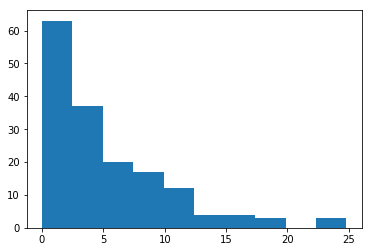

In [26]:
gaps = []
gaps.append(call_list[0].initial_time)
for i in range (1,len(call_list)-1):
    gaps.append(call_list[i].initial_time-call_list[i-1].initial_time)
    
plt.hist(gaps)
plt.show()

In [27]:
#travail restant à faire 
#Définir les interventions et calculer les différents temps 
#Faire la validation du modèle (impossible avec les données de l'ancien système')
#Faire les graphiques comparatifs avec le précédent modèle 
#2 problèmes : 
#1. Quand le SB est plus loin que l'AB, le SB est quand meme requisitionné 
#2. Quand le SB n'est pas encore arrivé a la base mais que l'AB est deja arrivé, l'AB ne peut pas partir tant que le SB n'est
#   pas arrivé 
 

In [28]:
tab = [1,2,3]
min(tab[-1], tab[2])

3